In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import shapely as shp
import hvplot.pandas 
import matplotlib.pyplot as plt

from geopandas import GeoDataFrame, read_file
from shapely.geometry import Point, LineString, Polygon
from datetime import datetime, timedelta
from holoviews import opts, dim
from os.path import exists
from urllib.request import urlretrieve

import warnings
warnings.filterwarnings('ignore')

plot_defaults = {'linewidth':5, 'capstyle':'round', 'figsize':(9,3), 'legend':True}
opts.defaults(opts.Overlay(active_tools=['wheel_zoom'], frame_width=300, frame_height=500))
hvplot_defaults = {'tiles':None, 'cmap':'Viridis', 'colorbar':True}
mpd.show_versions()


MovingPandas 0.16.0

SYSTEM INFO
-----------
python     : 3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)]
executable : C:\Users\midou\AppData\Local\Programs\Python\Python310\python.exe
machine    : Windows-10-10.0.19045-SP0

GEOS, GDAL, PROJ INFO
---------------------
GEOS       : None
GEOS lib   : None
GDAL       : 3.6.4
GDAL data dir: C:\Users\midou\AppData\Local\Programs\Python\Python310\lib\site-packages\fiona\gdal_data
PROJ       : 9.3.0
PROJ data dir: C:\Users\midou\AppData\Local\Programs\Python\Python310\lib\site-packages\pyproj\proj_dir\share\proj

PYTHON DEPENDENCIES
-------------------
geopandas  : 0.14.1
pandas     : 1.5.3
fiona      : 1.9.5
numpy      : 1.25.2
shapely    : 1.8.5.post1
rtree      : 1.1.0
pyproj     : 3.6.1
matplotlib : 3.8.2
mapclassify: 2.6.1
geopy      : 2.4.1
holoviews  : 1.18.1
hvplot     : 0.9.0
geoviews   : 1.11.0
stonesoup  : None


## Chargement des données


In [2]:
#%%time
df = read_file('oiseau.gpkg')
print(f"Finished reading {len(df)}")

Finished reading 89867


In [3]:
df.shape

(89867, 11)

In [4]:
df.columns

Index(['event-id', 'visible', 'timestamp', 'location-long', 'location-lat',
       'sensor-type', 'individual-taxon-canonical-name',
       'tag-local-identifier', 'individual-local-identifier', 'study-name',
       'geometry'],
      dtype='object')

Aperçu des données :

In [5]:
df.head()

,event-id,visible,timestamp,location-long,location-lat,sensor-type,individual-taxon-canonical-name,tag-local-identifier,individual-local-identifier,study-name,geometry
0,1082620685,true,2009-05-27 14:00:00.000,24.58617,61.24783,gps,Larus fuscus,91732,91732A,Navigation experiments in lesser black-backed ...,POINT (24.58617 61.24783)
1,1082620686,true,2009-05-27 20:00:00.000,24.58217,61.23267,gps,Larus fuscus,91732,91732A,Navigation experiments in lesser black-backed ...,POINT (24.58217 61.23267)
2,1082620687,true,2009-05-28 05:00:00.000,24.53133,61.18833,gps,Larus fuscus,91732,91732A,Navigation experiments in lesser black-backed ...,POINT (24.53133 61.18833)
3,1082620688,true,2009-05-28 08:00:00.000,24.58200,61.23283,gps,Larus fuscus,91732,91732A,Navigation experiments in lesser black-backed ...,POINT (24.58200 61.23283)
4,1082620689,true,2009-05-28 14:00:00.000,24.58250,61.23267,gps,Larus fuscus,91732,91732A,Navigation experiments in lesser black-backed ...,POINT (24.58250 61.23267)


In [6]:
df['visible'].value_counts()

true    89867
Name: visible, dtype: int64

L'ensemble des individus étudiés :

In [7]:
df['individual-local-identifier'].unique()

array(['91732A', '91733A', '91734A', '91735A', '91737A', '91738A',
       '91739A', '91740A', '91741A', '91742A', '91743A', '91744A',
       '91745A', '91746A', '91747A', '91748A', '91749A', '91750A',
       '91751A', '91752A', '91754A', '91755A', '91756A', '91758A',
       '91759A', '91761A', '91762A', '91763A', '91764A', '91765A',
       '91766A', '91767A', '91769A', '91771A', '91774A', '91775A',
       '91776A', '91777A', '91778A', '91779A', '91780A', '91781A',
       '91782A', '91783A', '91785A', '91786A', '91787A', '91788A',
       '91789A', '91794A', '91795A', '91797A', '91798A', '91799A',
       '91800A', '91802A', '91803A', '91807A', '91809A', '91810A',
       '91811A', '91812A', '91813A', '91814A', '91815A', '91816A',
       '91819A', '91821A', '91823A', '91824A', '91825A', '91826A',
       '91827A', '91828A', '91829A', '91830A', '91831A', '91832A',
       '91835A', '91836A', '91837A', '91838A', '91839A', '91843A',
       '91845A', '91846A', '91848A', '91849A', '91852A', '9185

## La distribution des individus :

<Axes: >

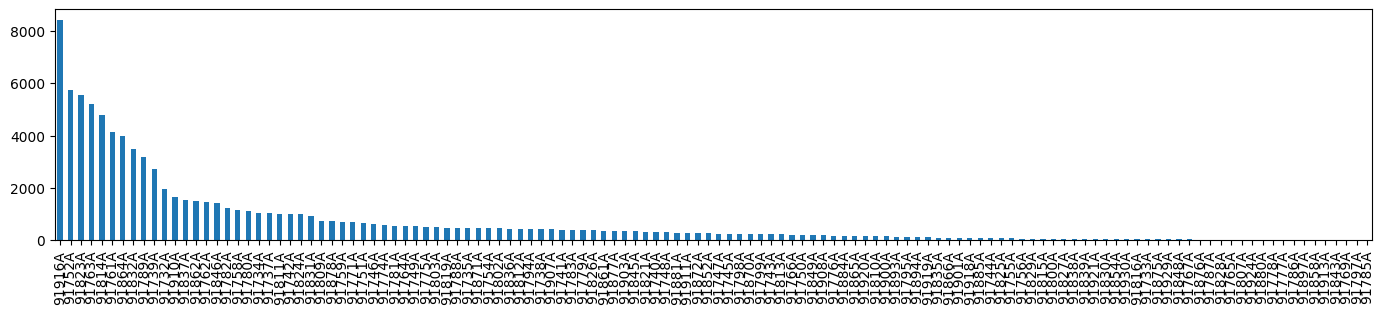

In [8]:
df['individual-local-identifier'].value_counts().plot(kind='bar', figsize=(17,3))

### On remarque que la distribution est inégale (91916A est dominant)

### Création des trajectoires

In [9]:
tc = mpd.TrajectoryCollection(df, 'individual-local-identifier', t='timestamp', min_length=100)    
tc
#min_length = plus petit nombre de trajectoires désiré

TrajectoryCollection with 125 trajectories

### Généralisation des trajectoires afin d'accélerer le processus d'analyse

In [10]:
tc = mpd.MinTimeDeltaGeneralizer(tc).generalize(tolerance=timedelta(days=1))

#### tolérance = 1 Jour : La généralisation dans ce cas consiste à considérer les points dont l'écart est à 1 jour similaires

## Exploration des trajectoires des oiseaux

L'individu '91916A' a le plus d'instances dans notre dataframe

In [11]:
filtered = tc.filter('individual-local-identifier', '91916A') #Filtrer la trajectoryCollection pour l'individu 91916A
my_traj = filtered.trajectories[0].copy() #Choisir la première trajectoire
my_traj.df.head()

,event-id,visible,location-long,location-lat,sensor-type,individual-taxon-canonical-name,tag-local-identifier,individual-local-identifier,study-name,geometry
timestamp,,,,,,,,,,
2009-08-15 15:00:00,1082625177,true,7.91500,54.18533,gps,Larus fuscus,91916,91916A,Navigation experiments in lesser black-backed ...,POINT (7.91500 54.18533)
2009-08-16 15:00:00,1082625181,true,9.44183,54.87233,gps,Larus fuscus,91916,91916A,Navigation experiments in lesser black-backed ...,POINT (9.44183 54.87233)
2009-08-17 15:00:00,1082625185,true,9.44250,54.87283,gps,Larus fuscus,91916,91916A,Navigation experiments in lesser black-backed ...,POINT (9.44250 54.87283)
2009-08-18 15:00:00,1082625189,true,9.41167,54.85550,gps,Larus fuscus,91916,91916A,Navigation experiments in lesser black-backed ...,POINT (9.41167 54.85550)
2009-08-19 15:00:00,1082625193,true,9.39583,54.88000,gps,Larus fuscus,91916,91916A,Navigation experiments in lesser black-backed ...,POINT (9.39583 54.88000)


In [12]:
my_traj.hvplot(title=f'Movement of {my_traj.id}', line_width=2) 

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Path.I   :Path   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (triangle_angle)

Cet individu a fait beaucoup de voyages au cours des années

On peut mieux explorer le comportement de cet individu en divisant ses voyages par année

In [35]:
trips_by_year = mpd.TemporalSplitter(filtered).split(mode='year') #TemporalSplitter sert à diviser la trajectoire de l'individu par année
trips_by_year.to_traj_gdf() #to_traj_gdf : donne un GeoDataFrame :

,traj_id,start_t,end_t,geometry,length,direction
0,91916A_2009-12-31 00:00:00,2009-08-15 15:00:00,2009-12-31 19:00:00,"LINESTRING (7.91500 54.18533, 9.44183 54.87233...",5.352375e+06,131.939002
1,91916A_2010-12-31 00:00:00,2010-01-01 19:00:00,2010-12-31 07:00:00,"LINESTRING (39.18417 21.17583, 39.18833 21.170...",1.232428e+07,281.047091
2,91916A_2011-12-31 00:00:00,2011-01-01 07:00:00,2011-12-31 04:00:00,"LINESTRING (39.17000 21.18017, 39.16883 21.156...",1.441793e+07,189.238229
3,91916A_2012-12-31 00:00:00,2012-01-01 04:00:00,2012-12-31 19:00:00,"LINESTRING (39.16933 21.16667, 39.17567 21.142...",1.324811e+07,62.132640
4,91916A_2013-12-31 00:00:00,2013-01-01 19:00:00,2013-12-31 13:00:00,"LINESTRING (39.18167 21.17333, 39.18100 21.173...",1.293261e+07,273.165851
5,91916A_2014-12-31 00:00:00,2014-01-01 13:00:00,2014-12-31 19:00:00,"LINESTRING (39.17083 21.15400, 39.17100 21.157...",1.300973e+07,33.742967
6,91916A_2015-12-31 00:00:00,2015-01-01 19:00:00,2015-08-27 09:00:00,"LINESTRING (39.18167 21.16967, 39.18233 21.169...",6.551740e+06,343.887905


#### On peut explorer chaque trajectoire pour chaque année :

In [36]:
one_year = trips_by_year.get_trajectory('91916A_2010-12-31 00:00:00')
one_year

Trajectory 91916A_2010-12-31 00:00:00 (2010-01-01 19:00:00 to 2010-12-31 07:00:00) | Size: 354 | Length: 12324280.3m
Bounds: (18.53417, 21.047, 39.203, 61.543)
LINESTRING (39.18417 21.17583, 39.18833 21.17083, 39.18767 21.172, 39.1865 21.17117, 39.18817 21.170

In [37]:
one_year.add_speed(units=("km", "h"))

In [38]:
one_year.hvplot(title=f'Movement speed of {one_year.id}', 
                line_width=5.0, c='speed', cmap='RdYlGn', colorbar=True, clim=(0,20)) 

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Path.I   :Path   [Longitude,Latitude]   (speed)
   .Points.I :Points   [Longitude,Latitude]   (speed,triangle_angle)

On peut visualiser l'emplacement de cet individu dans un jour quelconque

In [39]:
def plot_location_at_timestamp(traj, t, fig_size=250): # traj : notre trajectoire  t : date spécifique
    loc = GeoDataFrame([traj.get_row_at(t)]) # trouver la ligne qui vérifier la date t
    return (loc.hvplot(title=str(t), geo=True, tiles='OSM', size=200, color='red') * 
            traj.hvplot(line_width=1.0, color='black', tiles=False, width=fig_size, height=fig_size))

In [18]:
( plot_location_at_timestamp(one_year, datetime(2010,9,1)) + 
  plot_location_at_timestamp(one_year, datetime(2010,10,1)) +
  plot_location_at_timestamp(one_year, datetime(2010,11,1)) )

:Layout
   .Overlay.I   :Overlay
      .WMTS.I    :WMTS   [Longitude,Latitude]
      .Points.I  :Points   [Longitude,Latitude]
      .Path.I    :Path   [Longitude,Latitude]
      .Points.II :Points   [Longitude,Latitude]   (triangle_angle)
   .Overlay.II  :Overlay
      .WMTS.I    :WMTS   [Longitude,Latitude]
      .Points.I  :Points   [Longitude,Latitude]
      .Path.I    :Path   [Longitude,Latitude]
      .Points.II :Points   [Longitude,Latitude]   (triangle_angle)
   .Overlay.III :Overlay
      .WMTS.I    :WMTS   [Longitude,Latitude]
      .Points.I  :Points   [Longitude,Latitude]
      .Path.I    :Path   [Longitude,Latitude]
      .Points.II :Points   [Longitude,Latitude]   (triangle_angle)

Visualiser différentes emplacements dans un jour pour des années différentes :

In [42]:
def plot_location_at_day_of_year(traj, month, day, ax=None):
    ts = [datetime(year, month, day) for year in traj.df.index.year.unique()]
    return plot_locations_at_timestamps(traj, ts, ax=ax)

def plot_locations_at_timestamps(traj, ts, ax=None):  
    loc = GeoDataFrame([traj.get_row_at(t) for t in ts])
    loc['date_label'] = loc.index.strftime('%Y-%m-%d')
    return (loc.hvplot(title=f'Movement of {traj.id}', c='date_label', size=200, geo=True, tiles='OSM') *
            traj.hvplot(line_width=1.0, color='black', geo=True, tiles=False) )

In [43]:
plot_location_at_day_of_year(my_traj, month=10, day=1)

:Overlay
   .WMTS.I    :WMTS   [Longitude,Latitude]
   .Points.I  :Points   [Longitude,Latitude]   (date_label)
   .Path.I    :Path   [Longitude,Latitude]
   .Points.II :Points   [Longitude,Latitude]   (triangle_angle)

On peut remarquer que cet individu ne suit pas le même horaire et la même route chaque année. Cependant, il semble toujours se diriger vers la même région, la côte de la mer Rouge, quand c'est froid.

On peut trouver ses heures d'arrivée dans cette région :

In [21]:
area_of_interest = Polygon([(30, 25), (50, 25), (50, 15), (30, 15), (30, 25)]) 
plotted_area_of_interest = GeoDataFrame(pd.DataFrame([{'geometry': area_of_interest, 'id': 1}]), crs=4326).hvplot(geo=True, color='yellow', alpha=0.5)
# Ce polygone représente la zone d'intérêt

In [22]:
arrivals = [traj for traj in my_traj.clip(area_of_interest)] #Trouver les emplacements d'intérêt
print(f"Found {len(arrivals)} arrivals") #arrivals est une Liste des trajectoires incluses le polygone de zone d'intérêt

for traj in arrivals:
    print(f"Individual '{traj.df['individual-local-identifier'].iloc[0]}' arrived at {traj.get_start_time()}")
#Boucle for pour afficher pour chaque trajectoire l'individu avec sa date d'arrivé à l'endroit d'intérêt

Found 6 arrivals
Individual '91916A' arrived at 2009-12-23 02:58:36.946571
Individual '91916A' arrived at 2010-10-30 20:55:36.697832
Individual '91916A' arrived at 2011-11-09 20:25:19.550486
Individual '91916A' arrived at 2012-10-14 11:25:28.063070
Individual '91916A' arrived at 2013-10-08 04:17:33.524488
Individual '91916A' arrived at 2014-10-28 19:05:32.941608


In [23]:
( plot_locations_at_timestamps(my_traj, [traj.get_start_time() for traj in arrivals]) * plotted_area_of_interest )
#Visualisation de la zone d'intêrét

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Points.I   :Points   [Longitude,Latitude]   (date_label)
   .Path.I     :Path   [Longitude,Latitude]
   .Points.II  :Points   [Longitude,Latitude]   (triangle_angle)
   .Polygons.I :Polygons   [Longitude,Latitude]

## Exploration des trajectoires de plusieurs individus


In [24]:
year_of_interest = 2010
trajs_in_aoi = tc.clip(area_of_interest) #Clip est utilisée pour découper la zone d'intérêt
relevant = [ traj for traj in trajs_in_aoi if traj.get_start_time().year <= year_of_interest and traj.get_end_time().year >= year_of_interest]
# relevant : Liste qui sert à filtrer les trajectoires dans une seule année d'intérêt 
print("Found {} arrivals".format(len(relevant)))

Found 16 arrivals


#### Le but est de calculer la durée de séjour de certain individus afin de comprendre leurs comportements


In [25]:
for traj in relevant:
    print("Individual '{}' arrived at {} (duration: {})".format(
        traj.df['individual-local-identifier'].iloc[0], traj.get_start_time().date(), 
        traj.get_end_time()-traj.get_start_time()))

Individual '91732A' arrived at 2010-04-10 (duration: 5 days, 21:27:11.670985)
Individual '91737A' arrived at 2009-12-08 (duration: 140 days, 11:11:29.473206)
Individual '91761A' arrived at 2010-04-11 (duration: 12 days, 6:10:03.857850)
Individual '91761A' arrived at 2010-10-04 (duration: 6 days, 10:42:00.340093)
Individual '91762A' arrived at 2010-04-19 (duration: 42 days, 1:28:22.699066)
Individual '91771A' arrived at 2009-12-23 (duration: 66 days, 8:05:31.053782)
Individual '91789A' arrived at 2009-11-10 (duration: 550 days, 20:39:18.769409)
Individual '91824A' arrived at 2010-05-06 (duration: 12:53:53.409236)
Individual '91832A' arrived at 2010-04-21 (duration: 3 days, 5:48:46.276706)
Individual '91832A' arrived at 2010-09-23 (duration: 1 day, 1:40:25.175880)
Individual '91837A' arrived at 2010-05-04 (duration: 1 day, 18:38:46.170554)
Individual '91846A' arrived at 2010-05-15 (duration: 10 days, 2:50:28.505732)
Individual '91862A' arrived at 2010-01-06 (duration: 248 days, 6:10:16.9

En fonction de la durée des segments de trajectoire des individus dans notre zone d'intérêt, il semble que certains passent l'hiver ici tandis que d'autres ne font que traverser.

Par exemple, l'individu '91761A' a traversla zone d'intérêt é deux fois ? Que faisait-il?"

In [26]:
my_traj = tc.get_trajectory('91761A')
segment = my_traj.get_segment_between(datetime(year_of_interest,1,1), datetime(year_of_interest,12,31))

segment.hvplot(color='black', line_width=1.0) * plotted_area_of_interest 

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Path.I     :Path   [Longitude,Latitude]
   .Points.I   :Points   [Longitude,Latitude]   (triangle_angle)
   .Polygons.I :Polygons   [Longitude,Latitude]

il s'avérait que que cet individu ne reste pas à la mer Rouge mais poursuit son voyage en Afrique.